In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Importing modules

In [3]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants

import warnings
warnings.filterwarnings('ignore')

In [4]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
rootpath = os.getcwd()[:-15]
print(rootpath)
print('add path to PYTHONPATH : ', rootpath)
sys.path.insert(0, os.path.abspath(rootpath))

/Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2/
add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2/


In [5]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
pltext.style()

## Indications

### Objectives:

   * **Define an analysis** to select $\beta\beta0\nu$ events and reject background events using simulated data.

   * **Estimate the energy resolution**.
   
### Tasks:

   * **Define a selection**:
   
   * Open the data file (hdf5) and access the simulation data (MC) for the simulated samples: $^{214}\mathrm{Bi}$ and $^{208}\mathrm{Tl}$ (backgrounds), and the $\beta\beta0\nu$ signal.

   * Inspect the variables. Identify the most powerful ones.
   
   * Replicate the 'fanal' analysis, which is based on a set of cuts.

   * Define a selection (a list of cuts) and compare it with the 'fanal' analysis.
         
   * **Estimate the energy resolution** at the $Q_{\beta\beta}$ value.
   
### Notes: 
 
   * The variable *mcE* is the true energy, it is not measurable, and therefore it can not be used in any analysis!
   
   * The rest of the varaibles are "measurable" quantities and can be used in the analysis.

## Main parameters

In [6]:
coll          = 'new_beta'
ntracks_range = (     1,  1.1  )
eblob2_range  = ( 0.400,  1.200) # MeV
erange        = ( 2.400,  2.700) # MeV
eroi          = ( 2.430,  2.480) # MeV

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : ({:6.1f}, {:6.1f}) MeV'.format(*ntracks_range))
print('Blob-2 energy range       : ({:6.3f}, {:6.3f}) MeV'.format(*eblob2_range))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Collaboration             : new_beta
number of tracks range    : (   1.0,    1.1) MeV
Blob-2 energy range       : ( 0.400,  1.200) MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


In [7]:
# list of the selection variables names and ranges
varnames  = ['num_tracks', 'blob2_E', 'E', 'E']
varranges = [ntracks_range, eblob2_range, erange, eroi]
print('varnames  : ', varnames)
print('varranges : ', varranges)

varnames  :  ['num_tracks', 'blob2_E', 'E', 'E']
varranges :  [(1, 1.1), (0.4, 1.2), (2.4, 2.7), (2.43, 2.48)]


## Access the data

In [8]:
# set the path to the data directory and filenames
dirpath = rootpath+'/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

# access the simulated data (DataFrames) for the different samples (Bi, Tl, bb) located in the data file
mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

# set the names of the samples
mcs      = [mcbb, mcbi, mctl] # list of the mc DFs
tsamples = ['bb', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$', r'$^{214}$Bi', r'$^{208}$Tl'] # str names of the mc samples

for i, mc in enumerate(mcs):
    print('MC Sample {:s}, number of simulated events = {:d}'.format(tsamples[i], len(mc)))

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2//data/fanal_new_beta.h5
MC Sample bb, number of simulated events = 47636
MC Sample Bi, number of simulated events = 60184
MC Sample Tl, number of simulated events = 687297


## inspect the variables



In [9]:
# print the some contents of the DataFrame of the bb mc sample
mcbb

,mcE,E,num_tracks,num_voxels,track0_E,track0_voxels,track0_length,blob1_E,blob2_E,track1_E,track1_voxels,track1_length
0,2.457830,2.471280,1.0,17,2.471280,17.0,32.944061,NaN,NaN,NaN,NaN,NaN
1,1.627345,1.629487,1.0,13,1.629487,13.0,37.781500,0.841852,0.695263,NaN,NaN,NaN
2,2.457830,2.462075,1.0,14,2.462075,14.0,59.881962,0.961564,0.803745,NaN,NaN,NaN
3,2.457830,2.460759,1.0,21,2.460759,21.0,96.354208,1.005637,0.890549,NaN,NaN,NaN
4,2.457830,2.457934,2.0,20,2.428695,19.0,77.856795,NaN,NaN,0.029239,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
59993,2.457830,2.460685,1.0,16,2.460685,16.0,81.789893,1.051982,0.844432,NaN,NaN,NaN
59994,2.457830,2.461850,2.0,21,2.320462,19.0,74.822016,NaN,NaN,0.141387,2.0,17.020782
59996,2.457830,2.453377,1.0,22,2.453377,22.0,72.873822,0.902138,0.473505,NaN,NaN,NaN
59997,2.457830,2.455108,1.0,22,2.455108,22.0,35.444050,NaN,NaN,NaN,NaN,NaN


In [10]:
# list the variables
for label in mcbb.columns:
    print('variable : {:s}'.format(label))

variable : mcE
variable : E
variable : num_tracks
variable : num_voxels
variable : track0_E
variable : track0_voxels
variable : track0_length
variable : blob1_E
variable : blob2_E
variable : track1_E
variable : track1_voxels
variable : track1_length


**Exercise**: Understand the meaning of each variable (column) in the *DataFrame*

### Histogram the variables

  * Obtain the distribution of some variables in the energy range *erange*

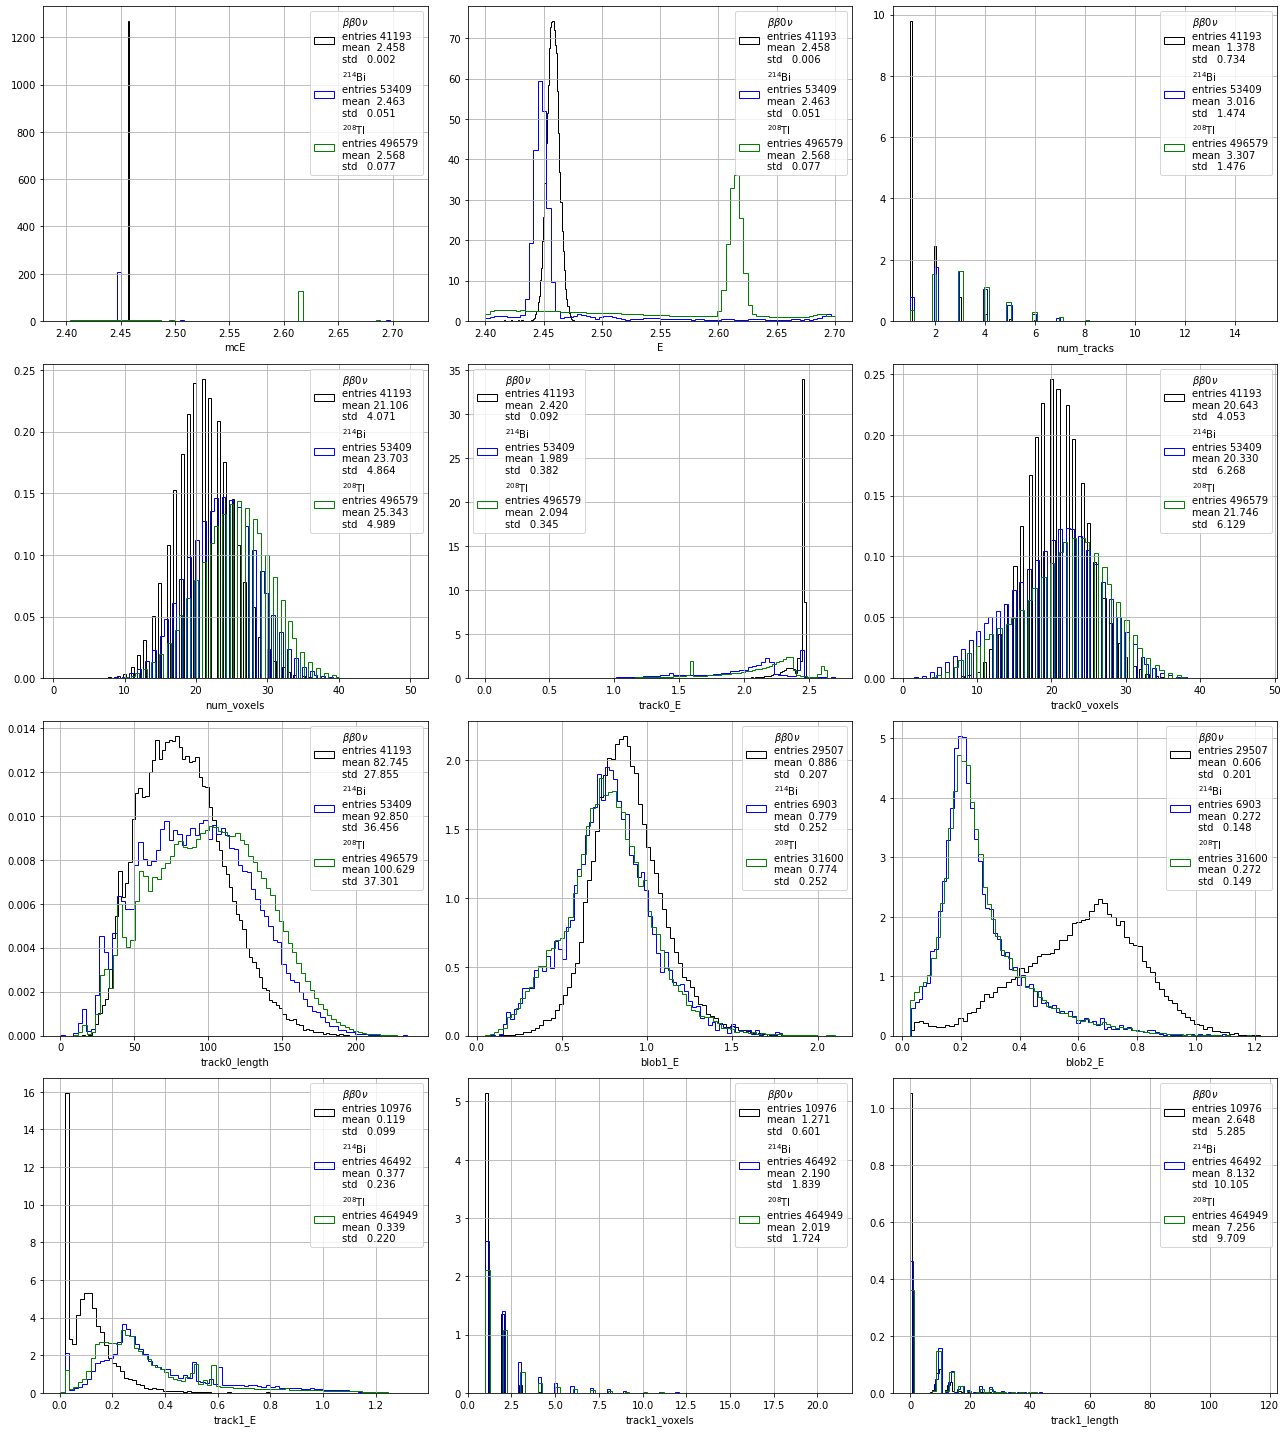

In [11]:
ename = 'E'

# filter the MC data-frames, consider only events with energy in *erange*
xmcs  = [mc[ut.selection(mc, ename, erange)] for mc in mcs]

# plot the distribution of all the variables of the Data Frame
pltext.dfs_inspect(xmcs, dfnames = ssamples, ncolumns = 3, bins = 80)

## Fanal analysis

The analysis selects a very pure sample of $\beta\beta0\nu$ applying a **set of cuts**. 

The objective is to define a selection with high efficiency on data and very large background rejection on background.

The *fanal* selection has the following cuts:
   
   * **One reconstructed track**. Most of the signal has only 1 track, while the background has in general more than one.
   
   * **Second blob energy**, the less energetic blob of the track must have at least an energy *eblob2* MeV. The signal has a blob, however the second blob of background tracks should be the initial extreme of the electron track and then should have smaller energy.

   * **Energy** of the event is on the *erange* MeV range (where the main photo peaks, Bi, Tl and $\beta\beta0\nu$, are).

   * **Energy Region of Interest (RoI)**. A zoom in the energy region, *eroi*, around the $Q_{\beta\beta}$ where lie most (all) events $$\beta\beta0\nu$.
   

### Plot the analysis variables 

Plot the variables of the analysis for the different MC samples.

In [12]:
def plt_fanal_mc(mcs, ssamples, bins = 100, erange = erange, eroi = eroi):
    """ Plot the relevant analysis variables, for the different mc samples
    """

    subplot = pltext.canvas(4)

    subplot(1)
    for i, mc in enumerate(mcs):
        sel  = ut.in_range(mc.E, erange)
        pltext.hist(mc.num_tracks[sel], int(bins/2), label = ssamples[i], density = True, range = (0, 15))
        plt.xlabel('number of tracks'); plt.title('E range')

    subplot(2)
    for i, mc in enumerate(mcs):
        sel  = ut.in_range(mc.E, erange) & mc.num_tracks == 1
        pltext.hist(mc.blob2_E[sel], bins,  label = ssamples[i], density = True)
        plt.xlabel('Energy blob2 (MeV)'); plt.title('E range - 1 track')
        
    subplot(3)
    for i, mc in enumerate(mcs):
        sel = (mc.E >= erange[0]) & (mc.E < erange[1])
        # sel = ut.in_range(mc.E, erange) equivalent using in_range method of utils
        pltext.hist(mc.E[sel], bins, label = ssamples[i], density = True)
        plt.xlabel('Energy (MeV)'); plt.title('E range');

    subplot(4)
    for i, mc in enumerate(mcs):
        sel  = (ut.in_range(mc.E, eroi)) & (mc.num_tracks == 1) & (mc.blob2_E >= 0.4)
        pltext.hist(mc.E[sel], bins,  label = ssamples[i], density = True)
        plt.xlabel('Energy  (MeV)'); plt.title('E RoI - 1 track - blob2 cut') 
    
    plt.tight_layout();
    return

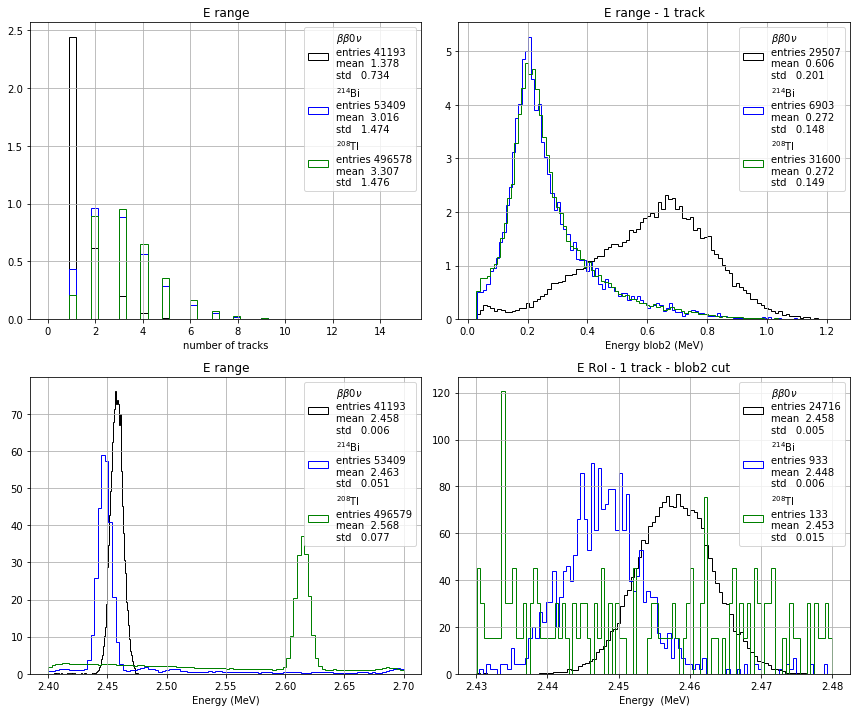

In [13]:
plt_fanal_mc(mcs, ssamples)

**Exercise**: Study the variables and decide wich ones have the larges discrimination power between signal and background.

## Efficiencies


  * Compute and plot the efficiencies of the cuts: 

      * One track.
  
      * Second blob Energy > *eblob2* MeV.
      
      * Energy range, *erange*.
  
      * Fine Energy range, RoI, *eroi*.

In [14]:
# names in the plot
effs, ueffs  = [], []
for i, mc in enumerate(mcs):
    xeffs = [ut.selection_efficiency(mc, varnames[:i], varranges[:i]) for i in range(1, len(varnames)+1)]
    ieffs, iueffs = ut.list_transpose(xeffs)
    effs.append(ieffs); ueffs.append(iueffs)
    
for i, ieffs in enumerate(effs):
    print('Efficiencies ' + tsamples[i], ': ', \
          *[' {:s} = {:6.5f}, '.format(s, eff) for s, eff in zip(varnames, ieffs)])

Efficiencies bb :   num_tracks = 0.71757,   blob2_E = 0.57713,   E = 0.51900,   E = 0.51879, 
Efficiencies Bi :   num_tracks = 0.14504,   blob2_E = 0.01929,   E = 0.01799,   E = 0.01550, 
Efficiencies Tl :   num_tracks = 0.04630,   blob2_E = 0.00734,   E = 0.00730,   E = 0.00019, 


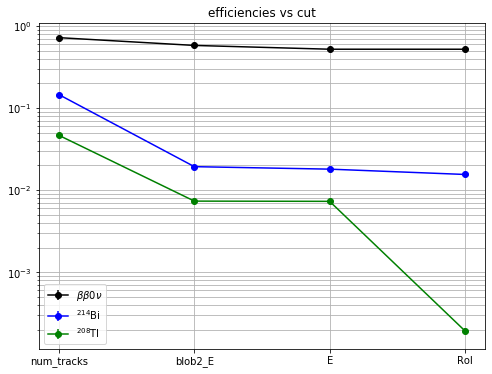

In [15]:
snames  = ['num_tracks', 'blob2_E', 'E', 'RoI']

subplot = pltext.canvas(1, 1, 6, 8)
subplot(1)
for i in range(len(effs)):
    plt.errorbar(snames, effs[i], yerr = ueffs[i], marker = 'o', label = ssamples[i])
plt.grid(which = 'both'); plt.yscale('log'); plt.legend();
plt.title('efficiencies vs cut');

**Exercises**:
    
   * Understand what is the most dangerous background.
    
   * Can you provide another selection that for the same background rejection increases the signal efficiency?
    
   * Identify the weak points of Fanal selection.

## Estimate the energy resolution 

The energy resolution is a crucial parameters in this analysis.

Fit the energy distribution of the photo-peaks of $^{214}\mathrm{Bi}$, $^{208}\mathrm{Tl}$ and the $\beta\beta0\nu$.

*Note*: Only the fit to $^{214}\mathrm{Bi}$ is shown, do similar fits to the  $^{208}\mathrm{Tl}$ and the $\beta\beta0\nu$ peacks.

Fit to a gaussian distribution or to a gaussian on top of a pedestal modeled with a straight line.

Give the relative energy resolution as the sigma/E or FWHM/E.

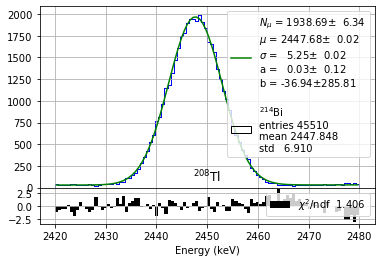

In [16]:
eranges = ((2420., 2480.), )
fitfuns = ('gausline',)
guesses =((10e3, 2445., 20., 0., 300.),)

isample = 1 # Bi
mc = mcs[isample]
label   = ssamples[isample]
resolutions = []
pltext.hist   (1e3 * mc.E, 100, range = eranges[0], label = label);
pars, _, _, _ = pltext.hfitres(1e3 * mc.E, 100, range = eranges[0], fun = fitfuns[0], guess = guesses[0])
resolutions.append((pars[2], pars[1])) # stores mu and sigma from the fit!
plt.xlabel('Energy (keV)'); plt.title(ssamples[i]);

In [17]:
sigma, fwhm = pars[0], 100 * 2.35 * pars[0]/pars[1]
print('Energy resolution {:s}: sigma {:6.2f} KeV, {:6.2f} % FWHM'.format(tsamples[isample], sigma, fwhm))

Energy resolution Bi: sigma 1938.69 KeV, 186.13 % FWHM


**Exercises**:
    
   * Ensure that the energy range used in the fit is adecuate.
    
   * Identify the $^{214}\mathrm{Bi}$ and $^{208}\mathrm{Tl}$ photo-peaks energies in the Literature.
   
   * Why is so important the energy resolution?

## Write out

*Note*: Be sure you have computed the right parameters and save then to the *collaboration* file.

Write out into the parameter file:

  * The selection variable names and ranges
  * The efficiencies of the selection.
  * The energy resolution.

*Exercise*: Store in the parameters file the values of the energy resolution of 3 samples.

In [18]:
write = True
if (write):
    of = open('collpars_.py', 'a')
    of.write('collaboration   = "' + coll + '"\n')
    of.write('ntracks_range   = ' + str(ntracks_range) + '\n')
    of.write('eblob2_range    = ' + str(eblob2_range) + ' # MeV\n')
    of.write('erange          = ' + str(erange) + ' # MeV\n')
    of.write('eroi            = ' + str(eroi)   + ' # MeV\n')
    for i, sample in enumerate(tsamples):
        of.write('eff_'+sample+'_E        = {:1.2e}'.format(effs[i][-2])+'\n')
        of.write('eff_'+sample+'_RoI      = {:1.2e}'.format(effs[i][-1])+'\n')
    #for i, sample in enumerate(tsamples):
    #    sigma = resolutions[i][0]
    #    of.write('sigma_'+sample+'        = {:1.2e} # keV'.format(sigma)+'\n')
    of.close()